In [1]:
import jax
from jax import lax, jit, vmap, random
import jax.numpy as jnp
import haiku as hk
import numpy as np
import optax
import string
import plotly.express as px

# ***Self-Attention Block***

### ***1) Setting up a Toy Dataset*** 

In [2]:
with open("dormeur_du_val.txt", "r", encoding="utf-8") as f:
    text = f.read().lower()
wo_punct = [letter for letter in text if letter not in string.punctuation]
tokens = "".join(wo_punct).split()
tokens[:9]

['cest', 'un', 'trou', 'de', 'verdure', 'où', 'chante', 'une', 'rivière']

In [3]:
SEQ_LEN = 10
VOCAB_SIZE = len(set(tokens))
EMBED_DIM = 16
BATCH_SIZE = 32
key = random.PRNGKey(0)

In [4]:
def collect_sequences(key:random.PRNGKey, data:list, seq_len:int, n_seq:int):
    sequences = []
    start_indexes = random.randint(key, (n_seq,), 0, len(data)-seq_len)
    for i in range(n_seq):
        sequences.append(data[start_indexes[i]:start_indexes[i]+seq_len])
    return sequences

sequences = collect_sequences(key, tokens, SEQ_LEN, BATCH_SIZE)

In [5]:
token_to_indices = {token:idx for idx, token in enumerate(set(tokens))}
encode_tokens = lambda sequence: [token_to_indices[token] for token in sequence]
encoded_sequences = jnp.array(list(map(encode_tokens, sequences)))
encoded_sequences.shape

(32, 10)

In [6]:
def embed_fn(tokenized_sequences):
    # creates a learnable lookup table of size vocab_size x embedding_dim
    embedding_layer = hk.Embed(VOCAB_SIZE, embed_dim=EMBED_DIM)
    return embedding_layer(tokenized_sequences)

# Haiku transform enables the init and apply functions
# without_apply_rng specifies that apply doesn't need a random key
embed = hk.without_apply_rng(hk.transform(embed_fn))

# param initialization
params = embed.init(jax.random.PRNGKey(0), encoded_sequences)
embeddings = embed.apply(params, encoded_sequences)
embeddings.shape

(32, 10, 16)

### ***2) Positional Encodings*** 
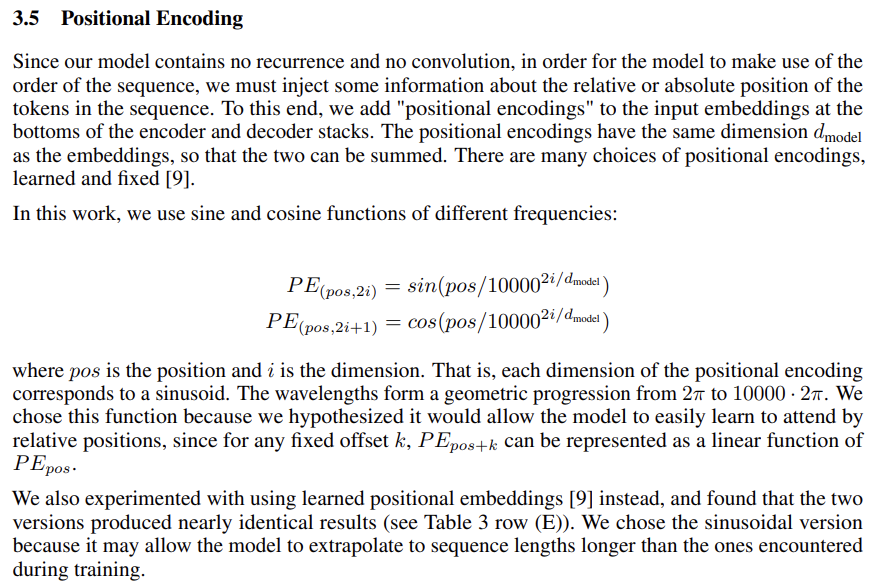

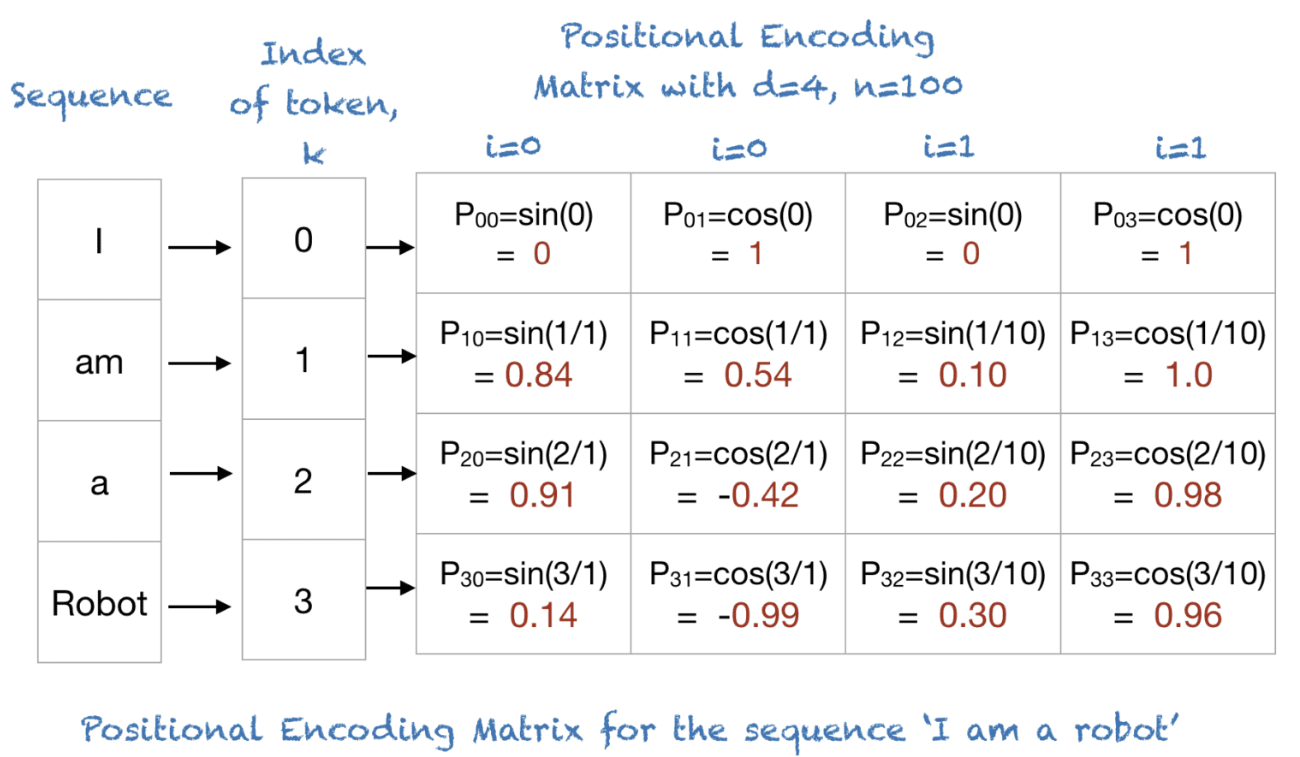

In [7]:
@jit
def positional_encoding(pos:int, dim:int, embed_dim:int):
    """
    Returns a single encoding for a single token
    """
    def _odd_encoding():
        return jnp.cos(pos / (jnp.power(10_000, 2*dim/embed_dim)))
    
    def _even_encoding():
        return jnp.sin(pos / (jnp.power(10_000, 2*dim/embed_dim)))
    
    is_even = (dim % 2 == 0)
    return lax.cond(
        is_even,
        _even_encoding,
        _odd_encoding
    )

@jit
def expanded_positional_encoding(pos, dim, embed_dim:int):
    """
    Returns embed_dim encodings for a single token
    """
    return vmap(
        positional_encoding,
        in_axes=(None, 0, None),
    )(pos, dim, embed_dim)

@jit
def batched_positional_encoding(pos, dim, embed_dim:int):
    """
    Returns embed_dim encodings for a sequence of tokens
    or a batch of sequences
    """
    return vmap(
        expanded_positional_encoding,
        in_axes=(0, None, None),
    )(pos, dim, embed_dim)

In [8]:
word_encoding = expanded_positional_encoding(encoded_sequences[0][0], jnp.arange(EMBED_DIM), EMBED_DIM)
word_encoding

Array([6.5028787e-01, 3.1022351e-02, 9.9749500e-01, 8.8959360e-01,
       1.4943813e-01, 9.9887520e-01, 1.4999438e-02, 9.9998873e-01,
       1.4999994e-03, 9.9999988e-01, 1.4999999e-04, 1.0000000e+00,
       1.5000000e-05, 1.0000000e+00, 1.5000001e-06, 1.0000000e+00],      dtype=float32)

In [9]:
batch_encoding = batched_positional_encoding(encoded_sequences, jnp.arange(EMBED_DIM), EMBED_DIM)
batch_encoding.shape

(32, 16, 10)